# SIR Model

The SIR model is a pretty adaptable workhorse model. So, a first step is programming up a few cases of this model. 

In the SIR model, we have:

$$
\begin{array}{ccc}
\dot{s} & = & - \beta i s\\
\dot{i} & = &  \beta i s - \nu i \\
\dot{r} & = & \nu i
\end{array}
$$

I just find it easier to work in discrete time so the time unit has a concrete interpretation. So:

What does the model look like in discrete time? 

It would be :

$$
\begin{array}{ccc}
s_{t+1} & = & s_t- \beta i_t s_t\\
i_{t+1} & = & i_t +\beta i_t s_t - \nu i_t \\
r_{t+1} & = & r_t+\nu i_t
\end{array}
$$

The following program is a simple simulator of the SIR model:

In [1]:
import numpy as np
from ipywidgets import interact, interact_manual, Layout
import matplotlib.pyplot as plt

def sirmodel(s0=.99, i0=.01, r0 =0, beta=.8, nu=.3, its=1000, tol=.005):
    
    '''Simulation of the SIR model. The model stops running when the number of infecteds 
       falls below tolerance or when the maximum iterations are reached.
       Tolerance must be less than i0 or the model will never 
       get going.'''
    
    S = []
    I = []
    R = []
    
    s = s0
    i = i0
    r = r0
    
    t=0
 
    while t<its and i> tol: 
        
        sp = s - beta*s*i
        ip = i + beta*s*i - nu*i
        rp = r + nu*i
        
        S.append(sp)
        I.append(ip)
        R.append(rp)
        
        s = sp
        i = ip
        r = rp
        
        t += 1
        
    return({'s':S, 'i':I, 'r':R})  

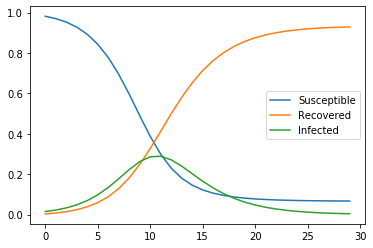

In [2]:
sim = sirmodel()
xs  = np.arange(len(sim['s']))

sline = plt.plot(xs, sim['s'])
rline = plt.plot(xs, sim['r'])
iline = plt.plot(xs, sim['i'])

legen = plt.legend(['Susceptible', 'Recovered', 'Infected'])

With this in mind, let's note that the model has very similar behavior to the SIR model, but is actually more aggresive in the way it models outbreaks. In any event, we can consider two regimes and a variable-time free sort of model. What would control of this model look like? 

# Controlling the outbreak:
- We might suppose that we can reduce $\beta$ by some amount, so that we have: $\beta=(1-z_t)$, but also let's suppose it is not possible to reduce it too much...
- There are costs of control, but let's suppose that actually enforcing the policy isn't all that costly. It is just social costs.
- Then, the costs per unit time are:

$$
c_t = c_t (z_t)
$$

Note that what we would really want is for this to be something like $c_t(z_tn_t)$, but our population is normalized at unity. We also have the costs of immediate care of infecteds, which we will suppose is $d_t(i_t)$. If we supposed some fraction of infecteds died, we could add this on here as well.

In [3]:
def sirmodel_pol(s0=.99, i0=.01, r0 =0, beta=.8, z=.5, zstart=0.00, zend=.05, nu=.3, its=1000, tol=.005):
    
    '''Simulation of the SIR model. The model stops running when the number of infecteds 
       falls below tolerance or when the maximum iterations are reached.
       Tolerance must be less than i0 or the model will never 
       get going.'''
    
    S = []
    I = []
    R = []
    Z = []
    
    s = s0
    i = i0
    r = r0
    
    t=0
    switch = 0
    zh = 0
 
    while t < its and i > tol: 
        
        if (i>=zstart) and (switch == 0):
            zh=z
            if (i > zend):
                switch = 1
                
        if (i<=zend) and (switch == 1):
            zh=0
        
        
        sp = s - beta*s*i*(1-zh)
        ip = i + beta*s*i*(1-zh) - nu*i
        rp = r + nu*i
        
        S.append(sp)
        I.append(ip)
        R.append(rp)
        Z.append(zh)
        
        s = sp
        i = ip
        r = rp
        
        t += 1
        
    return({'s':S, 'i':I, 'r':R, 'z':Z})  

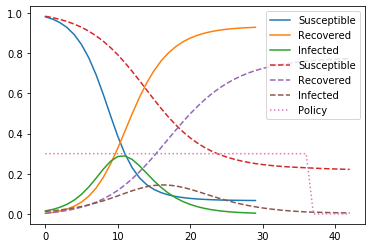

In [4]:
sim1 = sirmodel()
sim2 = sirmodel_pol(z=.3, zstart=0, zend=0.01)
xs1  = np.arange(len(sim1['s']))
xs2  = np.arange(len(sim2['s']))

sline  = plt.plot(xs1, sim1['s'])
rline  = plt.plot(xs1, sim1['r'])
iline  = plt.plot(xs1, sim1['i'])
slinep = plt.plot(xs2, sim2['s'], linestyle='dashed')
rlinep = plt.plot(xs2, sim2['r'], linestyle='dashed')
ilinep = plt.plot(xs2, sim2['i'], linestyle='dashed')
pline  = plt.plot(xs2, sim2['z'], linestyle='dotted')

legen = plt.legend(['Susceptible', 'Recovered', 'Infected', 'Susceptible', 'Recovered', 'Infected', 'Policy'])

In [5]:
print('Total periods of surpression:', np.sum(sim2['z']))
print('Total time length: ', len(sim2['z']))
print('Total infected: ', sim2['r'][-1])
print('Peak infection: ', np.max(sim2['i']))

# Without Policy

print('')

print('Total infected without intervention:', np.sum(sim1['r'][-1]))
print('Total time length: ', len(sim1['i']))
print('Total infected: ', sim1['r'][-1])
print('Peak infection: ', np.max(sim1['i']))

Total periods of surpression: 11.1
Total time length:  43
Total infected:  0.7735845167070784
Peak infection:  0.14442969054051294

Total infected without intervention: 0.9293550919346579
Total time length:  30
Total infected:  0.9293550919346579
Peak infection:  0.2886760211505085


In the SEIR model, we have:

$$
\begin{array}{ccc}
\dot{s} & = & - \beta i s\\
\dot{e} & = & \beta i s - \sigma e \\
\dot{i} & = &  \sigma e - \nu i \\
\dot{r} & = & \nu i
\end{array}
$$

I just find it easier to work in discrete time so the time unit has a concrete interpretation. So:

What does the model look like in discrete time? 

It would be :

$$
\begin{array}{ccc}
s_{t+1} & = & s_t- \beta i_t s_t\\
e_{t+1} & = & e_t + \beta i_t s_t - \sigma e_t \\
i_{t+1} & = & i_t +\sigma e_t - \nu i_t \\
r_{t+1} & = & r_t+\nu i_t
\end{array}
$$

In [6]:
import numpy as np

import matplotlib.pyplot as plt

def seirmodel(s0=.99, e0=0, i0=.01, r0 =0, beta=.8, nu=.3, sigma=.7, its=1000, tol=.005):
    
    '''Simulation of the SIR model. The model stops running when the number of infecteds 
       falls below tolerance or when the maximum iterations are reached.
       Tolerance must be less than i0 or the model will never 
       get going.'''
    
    S = []
    E = []
    I = []
    R = []
    
    s = s0
    e = e0
    i = i0
    r = r0
    
    t=0
 
    while t<its and i> tol: 
        
        sp = s - beta*s*i
        ep = e + beta*s*i - sigma*e
        ip = i + sigma*e - nu*i
        rp = r + nu*i
        
        S.append(sp)
        E.append(ep)
        I.append(ip)
        R.append(rp)
        
        s = sp
        e = ep
        i = ip
        r = rp
        
        t += 1
        
    return({'s':S, 'i':I, 'r':R, 'e':E})  

In [7]:
results = seirmodel()

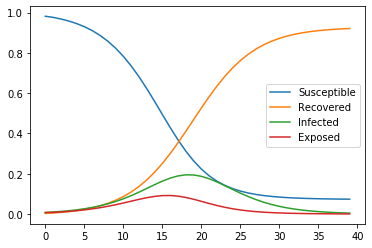

In [8]:
sim = seirmodel()
xs  = np.arange(len(sim['s']))

sline = plt.plot(xs, sim['s'])
rline = plt.plot(xs, sim['r'])
iline = plt.plot(xs, sim['i'])
eline = plt.plot(xs, sim['e'])

legen = plt.legend(['Susceptible', 'Recovered', 'Infected', 
                   'Exposed'])

# Acemoglu-Chernozhukov-Werning-Winston model

The "Acheww" model. Let's just write it down and then simulate the dynamics.

The basic equations of the model are three age groups:

$$
S_j(t)+I_j(t)+R_j(t)+D_j(t)=N_j
$$

We have $\sum N_j = 1$. 

$$
M_j = \left(\sum_k\beta_{jk}\left[(S_k+\eta_kI_k+(1-\kappa_k)R_k)(1-\theta_jL_k)+\kappa_kR_k\right]\right)^{\alpha-2}
$$

$$
\dot{I}_j = M_j(S,I,R,L)(1-\theta_jL_j)S_j\sum_k\beta_{jk}(1-\theta_kL_k)I_k - \gamma_jI_j
$$


Parameters obey:

$$
\beta_{jk}=\rho_{jk}(1-\iota_k\phi_k-(1-\iota_k)\tau_k)
$$

$$
\eta_k = 1-\iota_k\phi_k - (1-\iota_k)\tau_k
$$

$$
i_{1t+1} = i_{1t}(1-\iota_{1}(\delta_1^r+(1-\delta_1^r)\psi_1(h_t))-(1-\iota_1)\gamma_1) + m_1(1-\theta_1l_{1t})s_{1t}\sum_{k}(\beta_{1k}(1-\theta_{k}l_{kt})i_{kt}
$$
$$
i_{2t+1} = i_{2t}(1-\iota_{2}(\delta_2^r+(1-\delta_2^r)\psi_2(h_t))-(1-\iota_2)\gamma_2) + m_2(1-\theta_2l_{2t})s_{2t}\sum_{k}(\beta_{2k}(1-\theta_{k}l_{kt})i_{kt}
$$
$$
i_{3t+1} = i_{3t}(1-\iota_{3}(\delta_3^r+(1-\delta_2^r)\psi_3(h_t))-(1-\iota_3)\gamma_3) + m_3(1-\theta_3l_{3t})s_{3t}\sum_{k}(\beta_{3k}(1-\theta_{k}l_{kt})i_{kt}
$$

$\beta$ should be a matrix that has to be made square. 

Susceptibles obey:

$$
s_{1t+1} = s_{1t} - m_1(1-\theta_1l_{1t})s_{1t}\sum_{k}(\beta_{1k}(1-\theta_{k}l_{kt})i_{kt}
$$
$$
s_{2t+1} = s_{2t} - m_2(1-\theta_2l_{2t})s_{2t}\sum_{k}(\beta_{2k}(1-\theta_{k}l_{kt})i_{kt}
$$
$$
s_{3t+1} = s_{3t} - m_3(1-\theta_3l_{3t})s_{3t}\sum_{k}(\beta_{3k}(1-\theta_{k}l_{kt})i_{kt}
$$


Deaths:


$$
d_{1t+1} = d_{1t} + \delta_{1t}^di_{1t}
$$
$$
d_{2t+1} = d_{2t} - \delta_{2t}^di_{2t}
$$
$$
d_{3t+1} = d_{3t} - \delta_{3t}^di_{3t}
$$

Recoveries:

$$
r_{1t+1} = r_{1t} + \delta_{1t}^ri_{1t}
$$
$$
r_{2t+1} = r_{2t} + \delta_{2t}^ri_{2t}
$$
$$
r_{3t+1} = r_{3t} + \delta_{3t}^ri_{3t}
$$

How to program? Let's start with a base version of the model that does not have a "lockdown" policy. So, here we are omitting the variables $l_i$. I still retain the $\theta$ variables because we can see how this works as we move along.


# Optimal policies

To approximate the optimal policies derived by the authors, they typically have a shape where

- A strict lockdown tapers off over time
- Comparison of targeted versus untargeted lockdown
- Question of how testing and isolation can impact things. 
- Role of matching technology as well...

We need to calibrate the parameters and for this I will use the following - we can use a discretized version of their model where things are calculated by day. So, they have the population frequencies matching age groups as $N_1=.53, N_m=.26, N_o=.21$. We will suppose that patient zero is $N_m=.01$. 

They use a wage which is set to $w=1$ for all age groups except the old, for whom $w=0$. We have left out their $L$ variable, but it is $.7$ whenever there is a lock down. This would go under our $\theta$ parameter. 

They start with $\phi_j=\tau_j=0$ so this is a no-testing regime. $\kappa_j=1$ at the beginning.

A daily value of $\gamma=1/18$ is used. This translates to a discrete daily value of $1-e^{-\gamma}=p=.054$ in discrete time. They set $\rho=.2$, which comes out as $.181$ in a discrete model. They allege this matches estimates of $R_0$ for Covid. This is common for everyone, by the way. 

Daily mortality rates are $.001, .01, and .06$, all divided by 18. In discrete terms, these would be: $.0000555, $.00555$, and $.00333$, respectively.




In [31]:
def achewwmodel(s0=[.53, .26, .21], i0=[0, .01, 0], rho=[[.181, .181, .181], [.181, .181, .181], [.181, .181, .181]], 
                theta=[0, 0, 0], taper=[.1,.1,.1], sigma=40, gamma=[0.054, 0.054, 0.054], tau=[0, 0, 0],
                phi=[0, 0, 0], kappa = [1, 1, 1], dd=[0.000555, 0.00555, 0.00333], 
                dr=[.054, .054, .054], alpha=2, its=1000, tol=.005):
    
    '''This function simulates the ACHEWW model approximately. One should put in the maximal values of 
       the lockdown parameters theta, and then allow for taper (which functions like a rate of depreciation)
       after that. Additional policy parameters
       are static in that we suppose there is a fixed policy about isolation/detection/release. Taper can
       also be specific to age group, note.'''
    
    iota = [sigma*deathrate for deathrate in dd]
    
    eta = [1 - iota[0]*phi[0] - (1 - iota[0])*tau[0] ,
           1 - iota[1]*phi[1] - (1 - iota[1])*tau[1] ,
           1 - iota[2]*phi[2] - (1 - iota[2])*tau[2] ]
    
    beta = [[r*eta[0] for r in rho[0]],
            [r*eta[1] for r in rho[1]],
            [r*eta[2] for r in rho[2]] ]
    
    S1 = []
    S2 = []
    S3 = []

    I1 = []
    I2 = []
    I3 = []
    
    R1 = []
    R2 = []
    R3 = []
    
    H1 = []
    H2 = []
    H3 = []
    
    D1 = []
    D2 = []
    D3 = []
    
    s1, s2, s3 = s0[0], s0[1], s0[2]
    i1, i2, i3 = i0[0], i0[1], i0[2]
    r1, r2, r3 = 0, 0, 0
    d1, d2, d3 = 0, 0, 0
    
    t=0
    
    i = i1 + i2 + i3
 
    while t<its and i> tol: 
        
        # Compute matching function first
        
        m1 = ( beta[0][0]*((s1 + eta[0]*i1 + (1-kappa[0])*r1)*(1 - theta[0]) + kappa[0]*r1) + 
               beta[0][1]*((s2 + eta[1]*i2 + (1-kappa[1])*r2)*(1 - theta[1]) + kappa[1]*r2) +
               beta[0][2]*((s3 + eta[2]*i3 + (1-kappa[2])*r3)*(1 - theta[2]) + kappa[2]*r3)   )**(alpha - 2)
        m2 = ( beta[1][0]*((s1 + eta[0]*i1 + (1-kappa[0])*r1)*(1 - theta[0]) + kappa[0]*r1) +
               beta[1][1]*((s2 + eta[1]*i2 + (1-kappa[1])*r2)*(1 - theta[1]) + kappa[1]*r2) +
               beta[1][2]*((s3 + eta[2]*i3 + (1-kappa[2])*r3)*(1 - theta[2]) + kappa[2]*r3)   )**(alpha - 2)
        m3 = ( beta[2][0]*((s1 + eta[0]*i1 + (1-kappa[0])*r1)*(1 - theta[0]) + kappa[0]*r1) +
               beta[2][1]*((s2 + eta[1]*i2 + (1-kappa[1])*r2)*(1 - theta[1]) + kappa[1]*r2) +
               beta[2][2]*((s3 + eta[2]*i3 + (1-kappa[2])*r3)*(1 - theta[2]) + kappa[2]*r3)   )**(alpha - 2)
        
        num1 = (1 - theta[0])*s1*( beta[0][0]*i1*(1 - theta[0]) + beta[0][1]*i2*(1 - theta[1]) + 
               beta[0][2]*i3*(1 - theta[2])    )
        num2 = (1 - theta[1])*s2*( beta[1][0]*i1*(1 - theta[0]) + beta[1][1]*i2*(1 - theta[1]) + 
               beta[1][2]*i3*(1 - theta[2])    )
        num3 = (1 - theta[2])*s3*( beta[2][0]*i1*(1 - theta[0]) + beta[2][1]*i2*(1 - theta[1]) + 
               beta[2][2]*i3*(1 - theta[2])    )
        
        # Before next-period values let's compute statics like hospitalizations and all that
        # Current hospitalizations
        
        h1 = iota[0]*i1
        h2 = iota[1]*i2
        h3 = iota[2]*i3
        
        h = h1 + h2 + h3
        
        psi1 = 4*dd[0]*(1 + dd[0]*i1 + dd[1]*i2 + dd[2]*i3)
        psi2 = 4*dd[1]*(1 + dd[0]*i1 + dd[1]*i2 + dd[2]*i3)
        psi3 = 4*dd[2]*(1 + dd[0]*i1 + dd[1]*i2 + dd[2]*i3)
        
        i1p = i1 - i1*(1 - iota[0])*gamma[0] - h1*(dr[0] + (1-dr[0])*psi1) + m1*num1
        i2p = i2 - i2*(1 - iota[1])*gamma[1] - h2*(dr[1] + (1-dr[1])*psi2) + m2*num2
        i3p = i3 - i3*(1 - iota[2])*gamma[2] - h3*(dr[2] + (1-dr[2])*psi3) + m3*num3
        
        s1p = s1 - m1*num1
        s2p = s2 - m2*num2
        s3p = s3 - m3*num3

        r1p = r1 + i1*iota[0]*dr[0] + (1 - iota[0])*gamma[0]*i1 
        r2p = r2 + i2*iota[1]*dr[1] + (1 - iota[1])*gamma[1]*i2
        r3p = r3 + i3*iota[2]*dr[2] + (1 - iota[2])*gamma[2]*i3

        d1p = d1 + h1*(1-dr[0])*psi1
        d2p = d2 + h2*(1-dr[1])*psi2
        d3p = d3 + h3*(1-dr[2])*psi3 
        
        S1.append(s1p)
        S2.append(s2p)
        S3.append(s3p)

        I1.append(i1p)
        I2.append(i2p)
        I3.append(i3p)

        R1.append(r1p)
        R2.append(r2p)
        R3.append(r3p)

        D1.append(d1p)
        D2.append(d2p)
        D3.append(d3p)
        
        H1.append(h1)
        H2.append(h2)
        H3.append(h3)
        
        s1 = s1p
        s2 = s2p
        s3 = s3p

        i1 = i1p
        i2 = i2p
        i3 = i3p

        r1 = r1p
        r2 = r2p
        r3 = r3p

        d1 = d1p
        d2 = d2p
        d3 = d3p
        
        i = i1p + i2p + i3p
        t += 1
        
    return({'S':{'s1':S1, 's2':S2, 's3':S3}, 'I':{'i1':I1, 'i2':I2, 'i3':I3},
            'R':{'r1':R1, 'r2':R2, 'r3':R3}, 'D':{'d1':D1, 'd2':D2, 'd3':D3}, 
            'H':{'h1':H1, 'h2':H2, 'h3':H3}})  

In [32]:
res = achewwmodel()

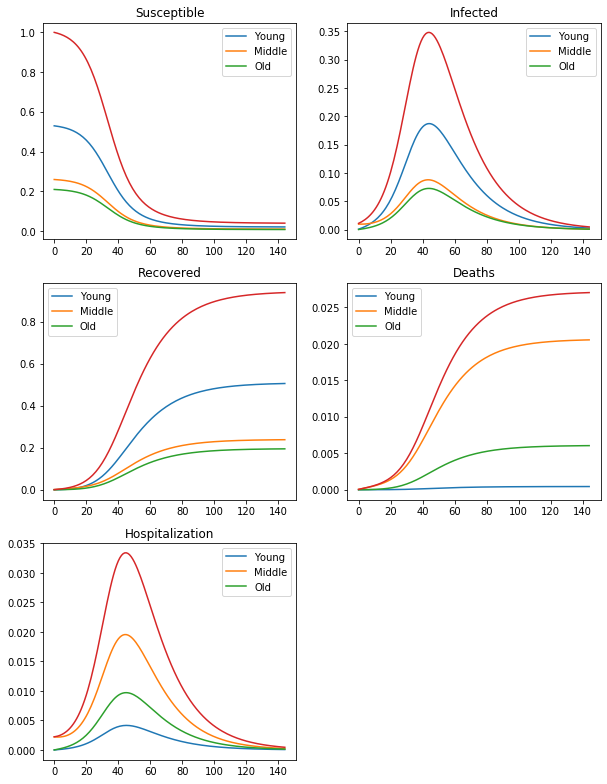

In [33]:
res['S']

fig = plt.figure(figsize=(10, 8))

axs = fig.add_subplot(3, 2, 1)
adj = fig.subplots_adjust(bottom=-.4)
xr  = np.arange(len(res['S']['s1']))
ls1 = axs.plot(xr, res['S']['s1'])
ls2 = axs.plot(xr, res['S']['s2'])
ls3 = axs.plot(xr, res['S']['s3'])

stotal = [s1 + s2 + s3 for s1, s2, s3 in zip(res['S']['s1'] , res['S']['s2'], res['S']['s3'])]

lst = axs.plot(xr, stotal)

sla = axs.legend(['Young', 'Middle', 'Old'])
stit = axs.title.set_text('Susceptible')

axi = fig.add_subplot(3, 2, 2)

xr  = np.arange(len(res['I']['i1']))
li1 = axi.plot(xr, res['I']['i1'])
li2 = axi.plot(xr, res['I']['i2'])
li3 = axi.plot(xr, res['I']['i3'])

itotal = [i1 + i2 + i3 for i1, i2, i3 in zip(res['I']['i1'] , res['I']['i2'], res['I']['i3'])]

lst = axi.plot(xr, itotal)

ila = axi.legend(['Young', 'Middle', 'Old'])
itit = axi.title.set_text('Infected')

axr = fig.add_subplot(3, 2, 3)

xr  = np.arange(len(res['R']['r1']))
lr1 = axr.plot(xr, res['R']['r1'])
lr2 = axr.plot(xr, res['R']['r2'])
lr3 = axr.plot(xr, res['R']['r3'])

rtotal = [r1 + r2 + r3 for r1, r2, r3 in zip(res['R']['r1'] , res['R']['r2'], res['R']['r3'])]

lst = axr.plot(xr, rtotal)

rla = axr.legend(['Young', 'Middle', 'Old'])
rtit = axr.title.set_text('Recovered')

axd = fig.add_subplot(3, 2, 4)

xr  = np.arange(len(res['D']['d1']))
ld1 = axd.plot(xr, res['D']['d1'])
ld2 = axd.plot(xr, res['D']['d2'])
ld3 = axd.plot(xr, res['D']['d3'])

dtotal = [d1 + d2 + d3 for d1, d2, d3 in zip(res['D']['d1'] , res['D']['d2'], res['D']['d3'])]

lst = axd.plot(xr, dtotal)

rla = axd.legend(['Young', 'Middle', 'Old'])
rtit = axd.title.set_text('Deaths')

axh = fig.add_subplot(3, 2, 5)
xr  = np.arange(len(res['H']['h1']))
ld1 = axh.plot(xr, res['H']['h1'])
ld2 = axh.plot(xr, res['H']['h2'])
ld3 = axh.plot(xr, res['H']['h3'])

htotal = [h1 + h2 + h3 for h1, h2, h3 in zip(res['H']['h1'] , res['H']['h2'], res['H']['h3'])]

lst = axh.plot(xr, htotal)

rla = axh.legend(['Young', 'Middle', 'Old'])
rtit = axh.title.set_text('Hospitalization')



Let's make a program that simulates this interactively. So, we will have a wrapper that collects everything into a program. Here goes:

In [34]:
def achewwmodel_wrap(s10=.28, s20=.49, s30=.22, i10=0, i20=.01, i30=0, b11=.2, b22=.2, 
                     b33=.2, b12=.2, b13=.2, b23=.2, theta1=0, theta2=0, theta3=0, dd1=.001,
                     dd2=.005, dd3=.1, dr1=.1, dr2=.1, dr3=.1, alpha=2, its=1000, tol=.005):

    s0 = [s10, s20, s30]
    i0 = [i10, i20, i30]
    b  = [[b11, b12, b13], [b12, b22, b23], [b13, b23, b33]]
    theta = [theta1, theta2, theta3]
    dd = [dd1, dd2, dd3]
    dr = [dr1, dr2, dr3]
    
    res = achewwmodel(s0=s0, i0=i0, b=b, theta=theta, dd=dd, dr=dr, alpha=alpha, its=its, tol=.005)
    
    fig = plt.figure(figsize=(14, 10))

    axs = fig.add_subplot(2, 2, 1)

    xr  = np.arange(len(res['S']['s1']))
    ls1 = axs.plot(xr, res['S']['s1'])
    ls2 = axs.plot(xr, res['S']['s2'])
    ls3 = axs.plot(xr, res['S']['s3'])

    stotal = [s1 + s2 + s3 for s1, s2, s3 in zip(res['S']['s1'] , res['S']['s2'], res['S']['s3'])]

    lst = axs.plot(xr, stotal)

    sla = axs.legend(['Young', 'Middle', 'Old'])
    stit = axs.title.set_text('Susceptible')

    axi = fig.add_subplot(2, 2, 2)

    xr  = np.arange(len(res['I']['i1']))
    li1 = axi.plot(xr, res['I']['i1'])
    li2 = axi.plot(xr, res['I']['i2'])
    li3 = axi.plot(xr, res['I']['i3'])

    itotal = [i1 + i2 + i3 for i1, i2, i3 in zip(res['I']['i1'] , res['I']['i2'], res['I']['i3'])]

    lst = axi.plot(xr, itotal)

    ila = axi.legend(['Young', 'Middle', 'Old'])
    itit = axi.title.set_text('Infected')

    axr = fig.add_subplot(2, 2, 3)

    xr  = np.arange(len(res['R']['r1']))
    lr1 = axr.plot(xr, res['R']['r1'])
    lr2 = axr.plot(xr, res['R']['r2'])
    lr3 = axr.plot(xr, res['R']['r3'])

    rtotal = [r1 + r2 + r3 for r1, r2, r3 in zip(res['R']['r1'] , res['R']['r2'], res['R']['r3'])]

    lst = axr.plot(xr, rtotal)

    rla = axr.legend(['Young', 'Middle', 'Old'])
    rtit = axr.title.set_text('Recovered')

    axd = fig.add_subplot(2, 2, 4)

    xr  = np.arange(len(res['D']['d1']))
    ld1 = axd.plot(xr, res['D']['d1'])
    ld2 = axd.plot(xr, res['D']['d2'])
    ld3 = axd.plot(xr, res['D']['d3'])

    dtotal = [d1 + d2 + d3 for d1, d2, d3 in zip(res['D']['d1'] , res['D']['d2'], res['D']['d3'])]

    lst = axd.plot(xr, dtotal)

    rla = axd.legend(['Young', 'Middle', 'Old', 'Total'])
    rtit = axd.title.set_text('Deaths')        

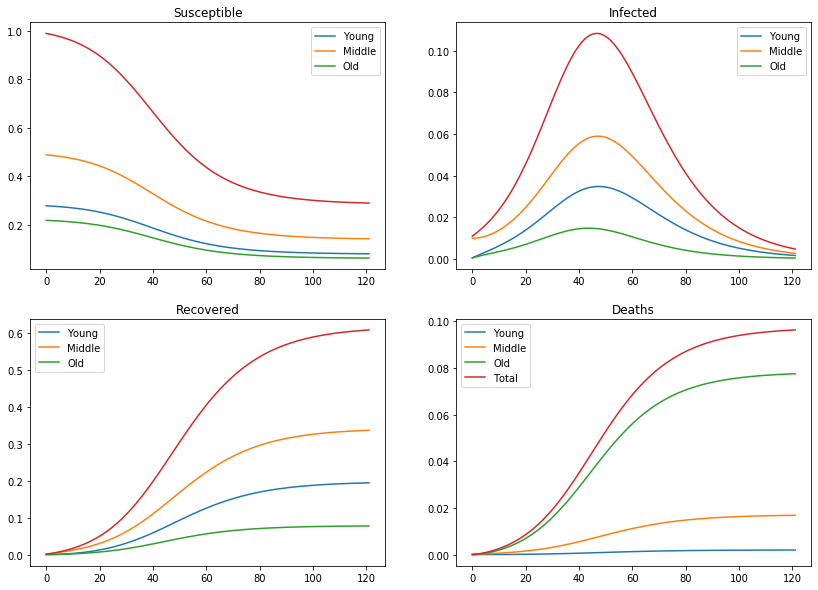

In [13]:
res = achewwmodel_wrap()